# Multivariate Time Series Forecasting with Transformer & SHAP

# Dataset: Air Quality (UCI) - https://archive.ics.uci.edu/ml/datasets/Air+Quality

In [ ]:
import pandas as pd

In [2]:
df = pd.read_excel(r"D:\OneDrive\Desktop\AirQualityUCI.xlsx");df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [3]:
df.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

# Model.py

Data loaded successfully:
- 9356 records
- Targets: CO(GT), PT08.S1(CO), NMHC(GT), C6H6(GT)
- Features: CO(GT), PT08.S1(CO), NMHC(GT), C6H6(GT), PT08.S2(NMHC), NOx(GT), PT08.S3(NOx), NO2(GT), PT08.S4(NO2), PT08.S5(O3), T, RH, AH, hour, day_of_week, month

Data sequences created:
- Train: 7465 sequences
- Test: 1867 sequences
- Input shape: (24, 16), Output shape: 4

Training model...
Epoch 1/50
117/117 [==============================] - 25s 131ms/step - loss: 0.0249 - val_loss: 0.0119 - lr: 0.0010
Epoch 2/50
117/117 [==============================] - 14s 116ms/step - loss: 0.0137 - val_loss: 0.0097 - lr: 0.0010
Epoch 3/50
117/117 [==============================] - 14s 118ms/step - loss: 0.0130 - val_loss: 0.0111 - lr: 0.0010
Epoch 4/50
117/117 [==============================] - 14s 119ms/step - loss: 0.0125 - val_loss: 0.0086 - lr: 0.0010
Epoch 5/50
117/117 [==============================] - 14s 122ms/step - loss: 0.0122 - val_loss: 0.0092 - lr: 0.0010
Epoch 6/50
117/117 [=============

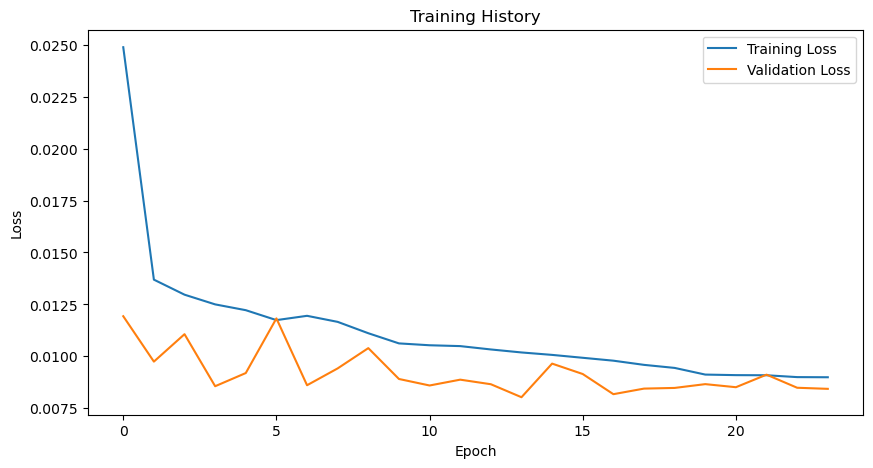

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_and_preprocess_data(file_path):
    
    df = pd.read_excel(file_path, header=0, skiprows=[1])
    

    df.columns = [str(col).strip().replace(' ', '_') for col in df.columns]
    
    
    df.replace(-200, np.nan, inplace=True)
    
  
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df['timestamp'] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    

    df = df.dropna(subset=['timestamp'])
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    
   
    df.interpolate(method='linear', inplace=True)
    df.dropna(inplace=True)
    

    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    

    target_cols = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)']
    feature_cols = [
        'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
        'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)',
        'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH',
        'hour', 'day_of_week', 'month'
    ]
    
  
    feature_cols = [col for col in feature_cols if col in df.columns]
    
    return df[['timestamp'] + feature_cols], target_cols, feature_cols

def create_sequences(data, targets, features, seq_length=24):
    # Normalization
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
    
        y.append(scaled_data[i+seq_length, :len(targets)])  
        
    X = np.array(X)
    y = np.array(y)
    
 
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    
    return X_train, y_train, X_test, y_test, scaler

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    x = MultiHeadAttention(
        key_dim=head_size, 
        num_heads=num_heads, 
        dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    
  
    y = Dense(ff_dim, activation="relu")(x)
    y = Dense(inputs.shape[-1])(y)
    y = Dropout(dropout)(y)
    return LayerNormalization(epsilon=1e-6)(x + y)

def build_model(input_shape, num_targets):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(2):  
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(num_targets)(x)
    return Model(inputs, outputs)

if __name__ == "__main__":
    
    SEQ_LENGTH = 24  
    EPOCHS = 50
    BATCH_SIZE = 64
    

    file_path = r"D:\OneDrive\Desktop\AirQualityUCI.xlsx"
    df, target_cols, feature_cols = load_and_preprocess_data(file_path)
    
    print("Data loaded successfully:")
    print(f"- {len(df)} records")
    print(f"- Targets: {', '.join(target_cols)}")
    print(f"- Features: {', '.join(feature_cols)}")
    
 
    X_train, y_train, X_test, y_test, scaler = create_sequences(
        df, target_cols, feature_cols, SEQ_LENGTH
    )
    
    print(f"\nData sequences created:")
    print(f"- Train: {X_train.shape[0]} sequences")
    print(f"- Test: {X_test.shape[0]} sequences")
    print(f"- Input shape: {X_train.shape[1:]}, Output shape: {y_train.shape[1]}")
    
   
    model = build_model((SEQ_LENGTH, len(feature_cols)), len(target_cols))
    model.compile(optimizer="adam", loss="mse")
    
  
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    print("\nTraining model...")
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )
    

    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f}")
    

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig("training_history.png")
    print("\nTraining history plot saved as 'training_history.png'")

    model.save("transformer_forecaster.h5")
    joblib.dump(scaler, "scaler.pkl")
    np.save("X_train.npy", X_train)
    np.save("X_test.npy", X_test)
    print("\nSaved artifacts:")
    print("- transformer_forecaster.h5 (model)")
    print("- scaler.pkl (normalization scaler)")
    print("- X_train.npy (training sequences)")
    print("- X_test.npy (test sequences)")
    
   
    sample = X_test[0:1]
    prediction = model.predict(sample)
    actual = y_test[0]
    
    print("\nSample prediction (normalized values):")
    for i, col in enumerate(target_cols):
        print(f"{col}:")
        print(f"  Actual: {actual[i]:.4f}, Predicted: {prediction[0][i]:.4f}, Error: {abs(actual[i]-prediction[0][i]):.4f}")

    print("\nTraining completed successfully!")

In [5]:
pip install shap --upgrade


Note: you may need to restart the kernel to use updated packages.


# Explaination of Model using SHAP

Initializing SHAP explainer...
Computing SHAP values...
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (5, 24, 16, 4)
Final SHAP values shape: (16,)
Number of features: 16
SHAP summary plot saved as 'shap_summary.png'

SHAP explanation completed!


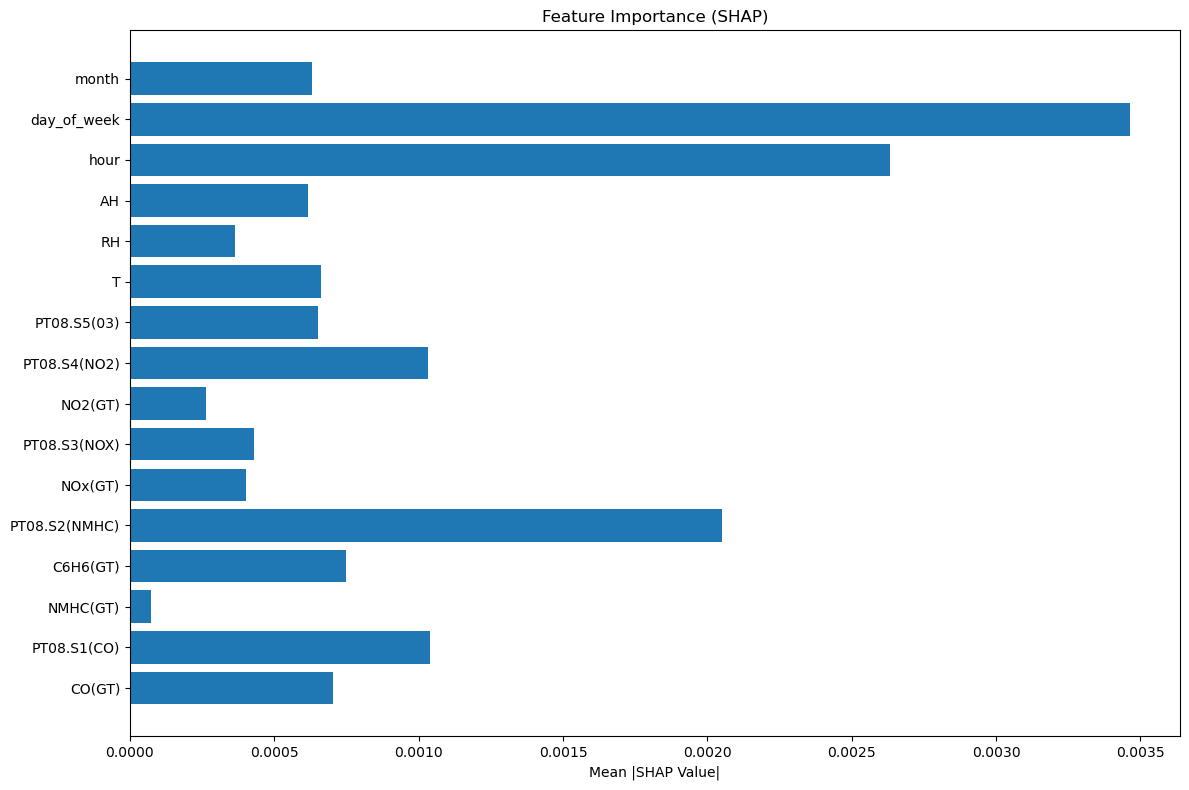

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
import joblib


model = tf.keras.models.load_model(r"C:\Users\Jibran\transformer_forecaster.h5")
scaler = joblib.load(r"C:\Users\Jibran\scaler.pkl")
X_train = np.load(r"C:\Users\Jibran\X_train.npy")
X_test = np.load(r"C:\Users\Jibran\X_test.npy")


background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]


print("Initializing SHAP explainer...")
explainer = shap.GradientExplainer(model, background)

test_samples = X_test[:5]  
print("Computing SHAP values...")
shap_values = explainer.shap_values(test_samples)

feature_cols = [
    'CO(GT)', 
    'PT08.S1(CO)',
    'NMHC(GT)',
    'C6H6(GT)',
    'PT08.S2(NMHC)',
    'NOx(GT)',
    'PT08.S3(NOX)',  
    'NO2(GT)',
    'PT08.S4(NO2)',
    'PT08.S5(03)',
    'T',
    'RH',
    'AH',
    'hour',
    'day_of_week',
    'month'
]


print(f"SHAP values type: {type(shap_values)}")
print(f"SHAP values shape: {shap_values.shape}")  


mean_shap = np.abs(shap_values).mean(axis=(0, 1, 3))  

print(f"Final SHAP values shape: {mean_shap.shape}") 
print(f"Number of features: {len(feature_cols)}")

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_cols, mean_shap)
plt.title("Feature Importance (SHAP)")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.savefig("shap_summary.png")
print("SHAP summary plot saved as 'shap_summary.png'")

print("\nSHAP explanation completed!")